In [1]:
import sys
from pathlib import Path

cwd = Path.cwd().resolve().parent
sys.path.append(str(cwd))


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import optimize

import utils as u
from visualization import papermode
from visualization import can_viz as canv

papermode(plt, size=18)


In [3]:
abbr = "P11"
filename = u.get_filename(abbr)
basename = u.get_basename(filename)
rundir = u.get_rundir(basename)

datadir = cwd / rundir
elec_data_path = datadir / "elec"
odom_data_path = datadir / "odom"
can_path = u.find_canlog(datadir)

figdir = cwd / "figs" / "thesis" / "experimental-setup"


In [4]:
can_df = u.read_canlog(can_path)
canL_df = can_df[can_df.frameID == '501'].copy()
canR_df = can_df[can_df.frameID == '502'].copy()

canL_df["packet"] = canL_df.can_packet.str[4:]
canR_df["packet"] = canR_df.can_packet.str[4:]
# canL_df["bytes_str"] = canL_df

u.decompose_packet(canL_df, "packet")
u.decompose_packet(canR_df, "packet")

canL_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canL.csv", index=False)
canR_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canR.csv", index=False)

In [5]:
mcu_path = elec_data_path / f"{basename}_elec_mcu_status.csv"
IL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_current.csv"
IR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_current.csv"
VL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_voltage.csv"
VR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_voltage.csv"
wL_path = odom_data_path / f"{basename}_odom_left_drive_status_speed.csv"
wR_path = odom_data_path / f"{basename}_odom_right_drive_status_speed.csv"

IL_df = pd.read_csv(IL_path)
IR_df = pd.read_csv(IR_path)
wL_df = pd.read_csv(wL_path)
wR_df = pd.read_csv(wR_path)
VL_df = pd.read_csv(VL_path)
VR_df = pd.read_csv(VR_path)
mcu_df = pd.read_csv(mcu_path)
mcu_df = mcu_df[["time","/mcu/status/current_battery"]].copy()

In [6]:
IL_df = IL_df.rename(columns={"/left_drive/status/battery_current": "IL"})
IR_df = IR_df.rename(columns={"/right_drive/status/battery_current": "IR"})
VL_df = VL_df.rename(columns={"/left_drive/status/battery_voltage": "VL"})
VR_df = VR_df.rename(columns={"/right_drive/status/battery_voltage": "VR"})
wL_df = wL_df.rename(columns={"/left_drive/status/speed": "wL"})
wR_df = wR_df.rename(columns={"/right_drive/status/speed": "wR"})
mcu_df = mcu_df.rename(columns={"/mcu/status/current_battery": "iBatt"})


In [7]:
time_min_odom = min(wL_df.time.min(), wR_df.time.min())
time_min_elec = min(IL_df.time.min(), IR_df.time.min())
time_min = min(time_min_elec, time_min_odom)

time_max_odom = max(wL_df.time.max(), wR_df.time.max())
time_max_elec = max(IL_df.time.max(), IR_df.time.max())
time_max = max(time_max_elec, time_max_odom)

reltime_max = time_max - time_min


In [8]:
IL_df["time_rel"] = IL_df.time - time_min
IR_df["time_rel"] = IR_df.time - time_min
VL_df["time_rel"] = VL_df.time - time_min
VR_df["time_rel"] = VR_df.time - time_min
wL_df["time_rel"] = wL_df.time - time_min
wR_df["time_rel"] = wR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min
mcu_df["time_rel"] = mcu_df.time - time_min


In [9]:
canL_mask = (canL_df.time_rel > 0) & (canL_df.time < time_max)
canL_df = canL_df[canL_mask].copy()

canR_mask = (canR_df.time_rel > 0) & (canR_df.time < time_max)
canR_df = canR_df[canR_mask].copy()

mcu_mask = (mcu_df.time_rel > 0) & (mcu_df.time < time_max)
mcu_df = mcu_df[mcu_mask].copy()

In [10]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Motor driver\ncurrent\ntransmitted on the\n\\texttt{ROS} topic (A)", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.set_ylim(bottom=0)

ax2.plot(canL_df.time_rel, canL_df.b3, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b3, label="Right")
ax2.legend(fontsize=12)
ax2.set_ylabel("Byte value\ntransmitted\nthrough\nthe \\texttt{CAN} bus", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
ax2.set_ylim(bottom=0, top=256)

ax2.set_xlim((0, 80))

fig.supxlabel("Time (s)", fontsize=18)

Text(0.5, 0.01, 'Time (s)')

In [11]:
fig, subfigs = plt.subplots(nrows=7, sharex=True, figsize=(6,14))
for idx, ax in enumerate(subfigs.reshape(-1)):
    ax.plot(canL_df.time_rel, canL_df[f"b{idx}"], label="Left")
    ax.plot(canR_df.time_rel, canR_df[f"b{idx}"], label="Right")
    ax.set_ylabel(f"Byte ${{{idx}}}$")
    ax.legend(fontsize=10)
    ax.yaxis.set_label_coords(-0.15, 0.5)

ax.set_xlim((0, reltime_max))

fig.supxlabel("Time (s)", fontsize=18)

Text(0.5, 0.01, 'Time (s)')

In [12]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Motor driver\ncurrent\ntransmitted on the\n\\texttt{ROS} topic (A)", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax1.set_ylim(bottom=0)
ax1.set_ylim(bottom=0, top=60)

ax2.plot(canL_df.time_rel, canL_df.b3, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b3, label="Right")
# ax2.plot(canL_df.time_rel, canL_df.b2, label="Left b2")
# ax2.plot(canR_df.time_rel, canR_df.b2, label="Right b2")
ax2.legend(fontsize=12)
ax2.set_ylabel("Transmitted\nbyte through\nthe \\texttt{CAN} bus", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
ax2.set_ylim(bottom=0, top=4)

ax2.set_xlim((0, 80))

fig.supxlabel("Time (s)", fontsize=18)

Text(0.5, 0.01, 'Time (s)')

In [13]:
can_df = u.read_canlog(can_path)
frameIDs = can_df.frameID.unique()
can_dfs = {fID: can_df[can_df.frameID == fID].copy() for fID in frameIDs}

for fID in frameIDs:
    frame_df = can_dfs[fID]
    frame_df["packet"] = frame_df.can_packet.str[4:]
    packet_len = frame_df.packet.str.len().unique()[0]
    u.decompose_packet(frame_df, "packet", n_bytes=packet_len//2)
    frame_df["time_rel"] = frame_df.time - time_min
    frame_mask = (frame_df.time_rel > 0) & (frame_df.time < time_max)
    frame_df = frame_df[frame_mask].copy()
    can_dfs[fID] = {"csv": frame_df, "len":packet_len//2}


In [14]:
print([f for f in sorted(can_dfs.keys())])


['000', '080', '181', '182', '201', '202', '281', '282', '381', '382', '401', '402', '481', '482', '501', '502', '701', '702', '740']


In [15]:
canv.plot_bytes("501", can_dfs=can_dfs, reltime_max=reltime_max);

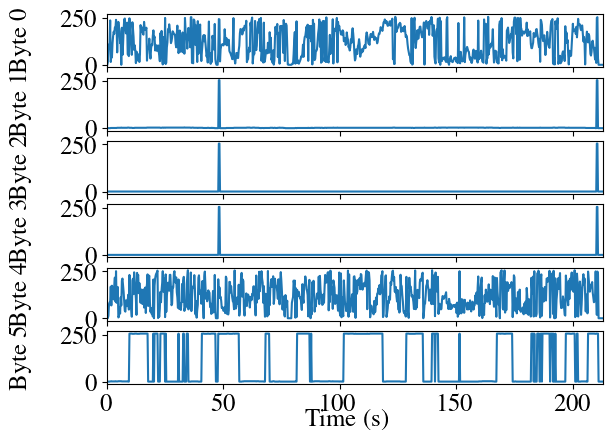

In [16]:
canv.plot_bytes("481", can_dfs=can_dfs, reltime_max=reltime_max);

In [17]:
canL_df.head()

time busID          can_packet frameID          packet  \
469758  1.662066e+09  can0  501#260301002B031E     501  260301002B031E   
470036  1.662066e+09  can0  501#1F039B0023031E     501  1F039B0023031E   
470314  1.662066e+09  can0  501#1B03FB0020031E     501  1B03FB0020031E   
470592  1.662066e+09  can0  501#1103990115031E     501  1103990115031E   
470870  1.662066e+09  can0  501#1303970116031E     501  1303970116031E   

                              bytes_str                       bytes  b0  b1  \
469758        b'&\x03\x01\x00+\x03\x1e'    [38, 3, 1, 0, 43, 3, 30]  38   3   
470036     b'\x1f\x03\x9b\x00#\x03\x1e'  [31, 3, 155, 0, 35, 3, 30]  31   3   
470314     b'\x1b\x03\xfb\x00 \x03\x1e'  [27, 3, 251, 0, 32, 3, 30]  27   3   
470592  b'\x11\x03\x99\x01\x15\x03\x1e'  [17, 3, 153, 1, 21, 3, 30]  17   3   
470870  b'\x13\x03\x97\x01\x16\x03\x1e'  [19, 3, 151, 1, 22, 3, 30]  19   3   

         b2  b3  b4  b5  b6  CAN_htemp  CAN_V  CAN_I  CAN_foo  time_rel  
469758    1   0  43   3  30         38    769     43      798  0.749638  
470036  155   0  35   3  30         31    923     35      798  1.749868  
470314  251   0  32   3  30         27   1019     32      798  2.750057  
470592  153   1  21   3  30         17    921    277      798  3.759765  
470870  151   1  22   3  30         19    919    278      798  4.759759

```tex
\documentclass{standalone}
\usepackage[utf8]{inputenc}
\usepackage{pgfplots}
\DeclareUnicodeCharacter{2212}{−}
\usepgfplotslibrary{groupplots,dateplot}
\usetikzlibrary{patterns,shapes.arrows}
\pgfplotsset{compat=newest}
```


In [18]:
# can_fit_dfs = {k:None for k in sorted(can_dfs.keys())}
# for frame_ID in can_fit_dfs.keys():
#     frame_df = can_dfs[frame_ID]["csv"]
#     packet_len = can_dfs[frame_ID]["len"]

#     fit_columns = ["time", *[f"b{i}" for i in range(packet_len)]]

#     canfit_df:pd.DataFrame = frame_df[fit_columns].copy()
#     can_fit_dfs[frame_ID] = canfit_df.reset_index(drop=True)
#     can_time = can_fit_dfs[frame_ID].time
#     if len(can_time) > 0:
#         IL_idx = pd.Series([(IL_df.time - can_time[idx]).abs().argmin() for idx in can_time.index]) 
#         IR_idx = pd.Series([(IR_df.time - can_time[idx]).abs().argmin() for idx in can_time.index])
#         # print(frame_ID, len(can_time), len(IL_df.IL))
#         can_fit_dfs[frame_ID]["IL"] = pd.Series([IL_df.IL.loc[idx] for idx in IL_idx])
#         can_fit_dfs[frame_ID]["IR"] = pd.Series([IR_df.IR.loc[idx] for idx in IR_idx])
#         can_fit_dfs[frame_ID]["1"] = pd.Series(1, can_time.index)

Text(0.5, 0.01, 'Time (s)')

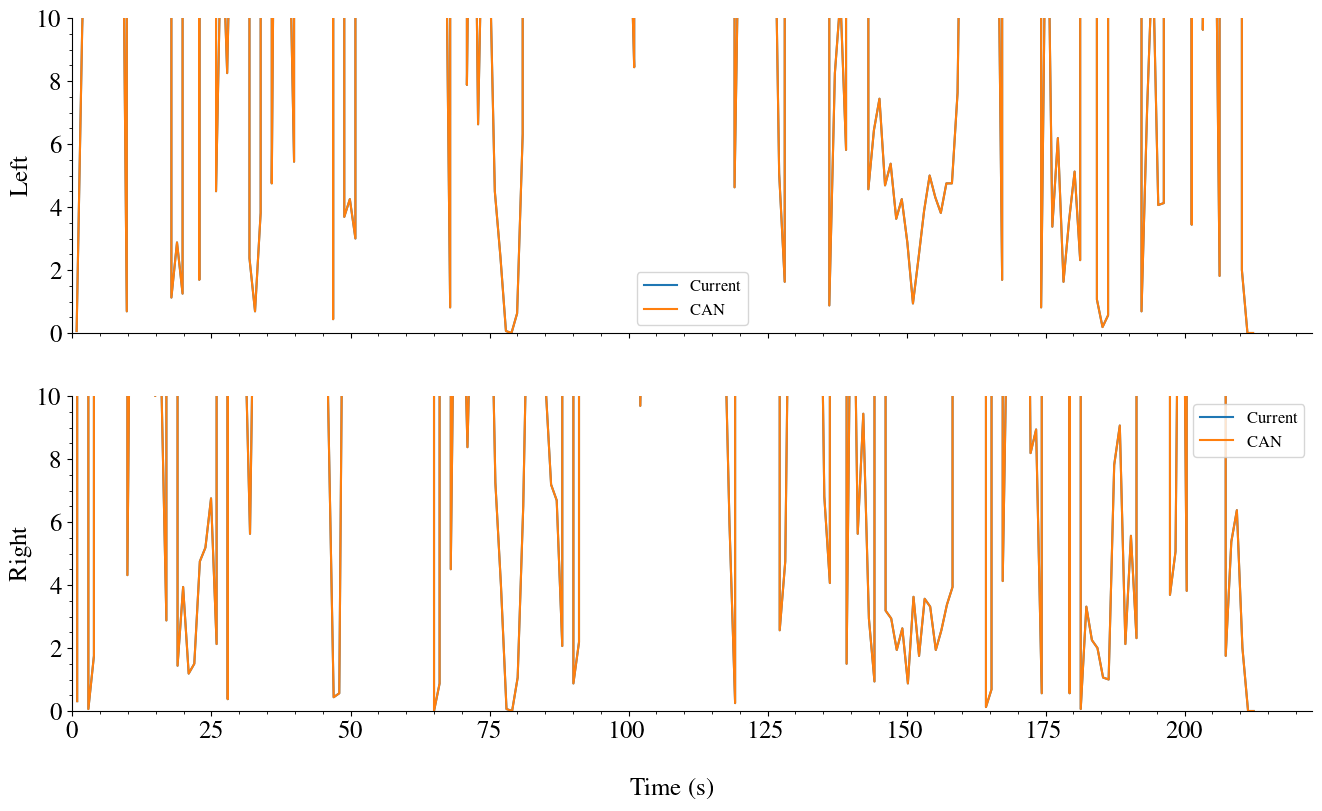

In [21]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(16, 9))
# fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, sharex=True, figsize=(15, 9))

packet_len = len(canL_df.columns) - 12
byte_columns = [f"b{i}" for i in range(packet_len)]
byte_arrL = canL_df[byte_columns].copy().to_numpy()
byte_arrR = canR_df[byte_columns].copy().to_numpy()
# coeffs = np.array([0, 1/256, 1/16, 16, 0, 0, 0])
coeffs = np.array([0, 0, 1/16, 16, 0, 0, 0])
canL_value = byte_arrL @ coeffs
canR_value = byte_arrR @ coeffs

ax1.plot(IL_df.time_rel, IL_df.IL, label="Current")
ax2.plot(IR_df.time_rel, IR_df.IR, label="Current")
ax1.plot(canL_df.time_rel, canL_value, label="CAN")
ax2.plot(canR_df.time_rel, canR_value, label="CAN")
# ax3.plot(canR_df.time_rel, canR_value - 127*16, label="Rectified")

ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
ax1.set_ylabel("Left")
ax2.set_ylabel("Right")
# ax3.set_ylabel("Byte")
ax1.spines[["right", "top"]].set_visible(False)
ax2.spines[["right", "top"]].set_visible(False)
# ax3.spines[["right", "top"]].set_visible(False)
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax3.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax3.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.set_ylim(bottom=0, top=10)
ax2.set_ylim(bottom=0, top=10)

ax2.set_xlim(left=0)

fig.supxlabel("Time (s)", fontsize=18)
